# Sparse Index Tracking — Starter Notebook

_Generated 2025-09-02_

This notebook provides a **clean, modular baseline** for building a sparse portfolio that tracks a benchmark (default **S&P 500, ^GSPC**). It includes:
- Data ingestion (tickers + prices via `pandas`/`yfinance`)
- Benchmark returns (^GSPC)
- Two methods:
  1. **Greedy forward selection + NNLS refit** (long-only, sum-to-one)
  2. **L1-regularized convex regression (cvxpy)** with long-only and budget constraint
- Train/validation split and basic metrics: in-sample/out-of-sample tracking error, number of names

You can later add:
- **Cardinality-constrained MIQP**, **factor-based tracking**, **sector caps**, and **turnover penalties**.

**Tip:** If Wikipedia scrape of S&P 500 tickers fails (network/policy), the code falls back to a small demonstration universe.


In [ ]:
# ---- Colab setup (safe to re-run) ----
import sys, subprocess, importlib

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Pins that play nicely with Colab's stack
required = {
    "numpy": "2.0.2",
    "pandas": "2.2.2",
    "scikit-learn": "1.6.1",
    "matplotlib": "3.10.0",
    "cvxpy": "1.6.7",
    "protobuf": ">=5.26.1,<6.0.0",
    "yfinance": None,
    "pulp": None,
    "ortools": "<9.11",   # optional; skip if you won't run MIQP today
}

to_install = []
for pkg, ver in required.items():
    try:
        importlib.import_module(pkg.replace("-", "_"))
    except ImportError:
        to_install.append(f"{pkg}{'=='+ver if ver and ver[0].isdigit() else (ver and ver) or ''}")

if to_install:
    print("Installing:", to_install)
    pip_install(to_install)

# Sanity check
import pandas as pd, numpy as np, cvxpy as cp, yfinance as yf, sklearn, matplotlib, pulp
print("OK:",
      "pandas", pd.__version__,
      "| numpy", np.__version__,
      "| cvxpy", cp.__version__,
      "| sklearn", sklearn.__version__,
      "| yfinance", yf.__version__)

In [8]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf

print("OK:",
      "pandas", pd.__version__,
      "| numpy", np.__version__,
      "| cvxpy", cp.__version__,
      "| sklearn", sklearn.__version__,
      "| yfinance", yf.__version__)

OK: pandas 2.2.2 | numpy 2.0.2 | cvxpy 1.6.7 | sklearn 1.6.1 | yfinance 0.2.65


In [11]:
np.set_printoptions(suppress=True, linewidth=120)
SEED = 42
np.random.seed(SEED)

In [6]:
# ===== Config =====
BENCHMARK = '^GSPC'   # S&P 500 index ticker in Yahoo Finance
TRAIN_YEARS = 3        # years in train window
TEST_YEARS = 1         # years in test window following train
FREQ = '1d'            # '1d' daily; can change to '1wk'
MAX_TICKERS = 500      # cap for universe size (S&P 500)
SEED = 42
np.random.seed(SEED)

# Dates
end_date = datetime.today().date()
start_date = end_date - timedelta(days=int((TRAIN_YEARS+TEST_YEARS)*365.25))
split_date = end_date - timedelta(days=int(TEST_YEARS*365.25))
start_date, split_date, end_date

(datetime.date(2021, 9, 2),
 datetime.date(2024, 9, 2),
 datetime.date(2025, 9, 2))

In [7]:
def get_sp500_tickers(max_n=500):
    """Try to fetch S&P 500 tickers from Wikipedia; fall back to a demo list if it fails."""
    try:
        tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        df = tables[0]
        tix = df['Symbol'].astype(str).str.replace('.', '-', regex=False).tolist()
        # Some tickers are weird (e.g., BRK.B -> BRK-B). Keep only alnum + '-'
        tix = [t for t in tix if len(t) > 0 and set(t) <= set('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-')]
        return tix[:max_n]
    except Exception as e:
        print('Wiki tickers fetch failed, using a small demo universe:', e)
        return ['AAPL','MSFT','NVDA','AMZN','GOOGL','META','BRK-B','JPM','XOM','UNH','JNJ','PG','AVGO','CVX','HD','LLY','ADBE','NFLX','MRK','PEP'][:max_n]

tickers = get_sp500_tickers(MAX_TICKERS)
len(tickers), tickers[:10]

Wiki tickers fetch failed, using a small demo universe: HTTP Error 403: Forbidden


(20,
 ['AAPL',
  'MSFT',
  'NVDA',
  'AMZN',
  'GOOGL',
  'META',
  'BRK-B',
  'JPM',
  'XOM',
  'UNH'])

In [12]:
def download_prices(tickers, start, end, interval='1d'):
    data = yf.download(tickers + [BENCHMARK], start=start, end=end, interval=interval, auto_adjust=True, progress=False)
    px = data['Close']
    # Drop tickers with all-NaN
    px = px.dropna(axis=1, how='all')
    # Forward-fill occasional gaps
    px = px.fillna(method='ffill')
    return px

prices = download_prices(tickers, start_date, end_date, FREQ)
prices.tail(3)


/tmp/ipython-input-1736115393.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  px = px.fillna(method='ffill')


Ticker,AAPL,ADBE,AMZN,AVGO,BRK-B,CVX,GOOGL,HD,JNJ,JPM,...,META,MRK,MSFT,NFLX,NVDA,PEP,PG,UNH,XOM,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-27,230.490005,356.350006,229.119995,300.250000,495.720001,159.240005,207.479996,408.239990,176.789993,299.279999,...,747.380005,84.070000,506.739990,1223.500000,181.600006,147.639999,156.960007,303.880005,112.750000,6481.399902
2025-08-28,232.559998,353.959991,231.600006,308.649994,499.859985,159.320007,211.639999,407.450012,175.449997,301.070007,...,751.109985,83.209999,509.640015,1231.449951,180.169998,146.979996,155.649994,302.290009,113.349998,6501.859863
2025-08-29,232.139999,356.700012,229.000000,297.390015,502.980011,160.600006,212.910004,406.769989,177.169998,301.420013,...,738.700012,84.120003,506.690002,1208.250000,174.179993,148.649994,157.039993,309.869995,114.290001,6460.259766


In [13]:
# Compute simple returns
rets = prices.pct_change().dropna(how='all')
rets = rets.loc[rets.index >= pd.to_datetime(start_date)]
rets = rets.dropna(axis=1, how='any')  # keep only full-history names for simplicity

# Separate benchmark and stock matrix
r_b = rets[BENCHMARK]
R = rets.drop(columns=[BENCHMARK])

print('Shapes -> R:', R.shape, 'r_b:', r_b.shape)
R.head(3)


Shapes -> R: (1001, 20) r_b: (1001,)


Ticker,AAPL,ADBE,AMZN,AVGO,BRK-B,CVX,GOOGL,HD,JNJ,JPM,LLY,META,MRK,MSFT,NFLX,NVDA,PEP,PG,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,
2021-09-03,0.004231,0.002934,0.004311,0.01175,-0.011086,-0.002252,0.003158,0.007933,0.000629,-0.006045,-0.000154,0.002611,0.001815,-0.000033,0.003364,0.019959,0.000892,0.000695,-0.002006,-0.003813
2021-09-07,0.015489,-0.007801,0.008982,-0.00219,-0.010607,-0.004411,0.003764,-0.004207,-0.015539,-0.001756,-0.018225,0.015734,-0.016568,-0.003188,0.027399,-0.007924,-0.016296,-0.003749,-0.003831,-0.005832
2021-09-08,-0.010084,0.002767,0.004619,-0.00445,0.001578,-0.006903,-0.004086,0.007995,-0.002437,-0.004459,0.000157,-0.012062,-0.008160,0.000100,-0.001088,-0.014253,0.014172,0.007596,-0.013888,-0.009166


In [14]:
# Train/validation split (time-based)
train_mask = R.index < pd.to_datetime(split_date)
R_tr, R_te = R.loc[train_mask], R.loc[~train_mask]
rb_tr, rb_te = r_b.loc[train_mask], r_b.loc[~train_mask]
R_tr.shape, R_te.shape, rb_tr.shape, rb_te.shape


((752, 20), (249, 20), (752,), (249,))

In [15]:
def nnls_sum_to_one(R, r, idx=None):
    """Solve min ||R w - r||^2 s.t. w>=0, 1'w=1. If idx provided, restrict to those columns."""
    if idx is not None:
        R_ = R.iloc[:, idx].values
    else:
        R_ = R.values
    r_ = r.values.reshape(-1,1)
    n = R_.shape[1]
    w = cp.Variable((n,1))
    obj = cp.Minimize(cp.sum_squares(R_ @ w - r_))
    cons = [w >= 0, cp.sum(w) == 1]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return None, np.inf
    wv = w.value.flatten()
    resid = (R_ @ w.value - r_).flatten()
    te = np.std(resid) * np.sqrt(252)  # daily -> annualized TE
    return wv, te

def greedy_forward_nnls(R, r, k=15):
    """Greedy selection by correlation, with NNLS refit (sum-to-one) at each step."""
    remaining = list(range(R.shape[1]))
    chosen = []
    w = None
    resid = r.values.copy()
    for step in range(k):
        # Pick the column with highest |corr| to current residual
        corr = np.abs(np.corrcoef(R.values.T, resid)[R.shape[1]:, :R.shape[1]].diagonal()) if False else None
        # Simpler & robust: brute-force best next feature by NNLS fit improvement
        best_i, best_te = None, np.inf
        for i in remaining:
            idx = chosen + [i]
            w_try, te_try = nnls_sum_to_one(R, r, idx)
            if te_try < best_te:
                best_te = te_try
                best_i = i
        chosen.append(best_i)
        remaining.remove(best_i)
        w, te = nnls_sum_to_one(R, r, chosen)
        # Update residual for logging (not used for selection to keep it simple)
        resid = r.values - R.iloc[:, chosen].values @ w.reshape(-1,1)
        # print(f"Step {step+1}: added {R.columns[best_i]}, TE~{te:.2f} bp")
    return chosen, w, te

def l1_cvx(R, r, lam=1.0):
    """Solve min ||R w - r||^2 + lam * ||w||_1 s.t. w>=0, 1'w=1."""
    R_ = R.values
    r_ = r.values.reshape(-1,1)
    n = R_.shape[1]
    w = cp.Variable((n,1))
    obj = cp.Minimize(cp.sum_squares(R_ @ w - r_) + lam * cp.norm1(w))
    cons = [w >= 0, cp.sum(w) == 1]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return None, np.inf
    wv = w.value.flatten()
    resid = (R_ @ w.value - r_).flatten()
    te = np.std(resid) * np.sqrt(252)
    return wv, te

def evaluate_te(R, r, w):
    resid = r.values - R.values @ w
    return float(np.std(resid) * np.sqrt(252))

def portfolio_returns(R, w):
    return pd.Series(R.values @ w, index=R.index)


Chosen (15): ['BRK-B', 'MSFT', 'AVGO', 'HD', 'AAPL', 'JPM', 'PEP', 'AMZN', 'NVDA', 'CVX', 'PG', 'META', 'UNH', 'GOOGL', 'LLY']
In-sample TE (annualized, bp): 0.04
Out-of-sample TE (annualized, bp): 0.05


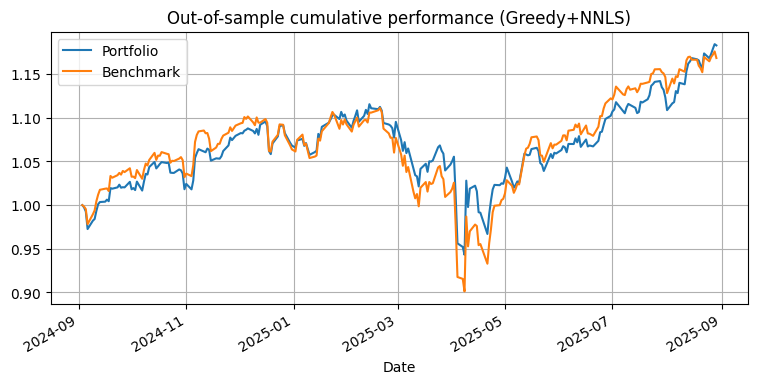

In [16]:
# ===== Approach A: Greedy forward + NNLS on TRAIN, evaluate on TEST =====
K = 15
chosen, w_tr, te_tr = greedy_forward_nnls(R_tr, rb_tr, k=K)
names = R_tr.columns[chosen]
print(f"Chosen ({len(chosen)}):", list(names))
print(f"In-sample TE (annualized, bp): {te_tr:.2f}")

# Evaluate on test
w_full = np.zeros(R_tr.shape[1])
w_full[chosen] = w_tr
te_te = evaluate_te(R_te.iloc[:, :], rb_te, w_full)
print(f"Out-of-sample TE (annualized, bp): {te_te:.2f}")

# Build test period cumulative returns vs benchmark
port_te = portfolio_returns(R_te.iloc[:, :], w_full)
cum_port = (1 + port_te).cumprod()
cum_bench = (1 + rb_te).cumprod()
ax = (cum_port.rename('Portfolio') / cum_port.iloc[0]).plot(figsize=(9,4))
((cum_bench.rename('Benchmark') / cum_bench.iloc[0])).plot(ax=ax)
plt.title('Out-of-sample cumulative performance (Greedy+NNLS)')
plt.legend(); plt.grid(True); plt.show()


lam=10.000 -> OOS TE=0.05 bp, nnz=20
lam=4.642 -> OOS TE=0.05 bp, nnz=20
lam=2.154 -> OOS TE=0.05 bp, nnz=20
lam=1.000 -> OOS TE=0.05 bp, nnz=20
lam=0.464 -> OOS TE=0.05 bp, nnz=20
lam=0.215 -> OOS TE=0.05 bp, nnz=20
lam=0.100 -> OOS TE=0.05 bp, nnz=20
lam=0.046 -> OOS TE=0.05 bp, nnz=20
lam=0.022 -> OOS TE=0.05 bp, nnz=20
lam=0.010 -> OOS TE=0.05 bp, nnz=20

Best lam=10.0000; nnz=20; OOS TE=0.05 bp


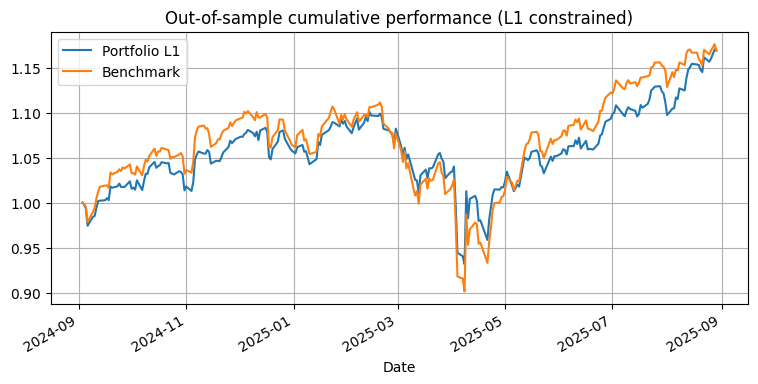

In [17]:
# ===== Approach B: L1-regularized convex regression (with constraints) =====
lams = np.geomspace(10.0, 0.01, 10)
best = (None, None, np.inf)
for lam in lams:
    w_l1, te_in = l1_cvx(R_tr, rb_tr, lam=float(lam))
    if w_l1 is None:
        continue
    te_out = evaluate_te(R_te, rb_te, w_l1)
    nnz = int((w_l1 > 1e-6).sum())
    # Simple score: prioritize low out-of-sample TE, break ties with sparsity
    score = te_out + 0.01 * nnz
    print(f"lam={lam:.3f} -> OOS TE={te_out:.2f} bp, nnz={nnz}")
    if score < best[2]:
        best = (w_l1, lam, score)

w_best, lam_best, _ = best
if w_best is not None:
    print(f"\nBest lam={lam_best:.4f}; nnz={int((w_best>1e-6).sum())}; OOS TE={evaluate_te(R_te, rb_te, w_best):.2f} bp")
    port_te2 = portfolio_returns(R_te, w_best)
    cum_port2 = (1 + port_te2).cumprod()
    cum_bench2 = (1 + rb_te).cumprod()
    ax = (cum_port2.rename('Portfolio L1') / cum_port2.iloc[0]).plot(figsize=(9,4))
    ((cum_bench2.rename('Benchmark') / cum_bench2.iloc[0])).plot(ax=ax)
    plt.title('Out-of-sample cumulative performance (L1 constrained)')
    plt.legend(); plt.grid(True); plt.show()
else:
    print('L1 solver failed to find a solution. Try adjusting the lambda grid or OSQP install.')


## Next steps
- Add **sector caps**: restrict weights by sector buckets.
- Add **turnover penalty**: fit sequentially over time with \(\|w_t - w_{t-1}\|_1\) penalty.
- Try **MIQP** with cardinality (\(\sum z_i \le k\)). Use `pulp` or `ortools`.
- Build **factor exposures** (PCA or Fama–French-style) and solve a smaller problem matching exposures.
- Replace benchmark returns with an **equal-weight** or **custom synthetic** benchmark to avoid mega-cap dominance.
